Initial generation: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)NO)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -9.16
Iteration 1: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)NCc5ccccc5)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -10.35
Iteration 2: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)Nc5ccc(Cl)cc5)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -5.13
Iteration 3: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)Nc5ccc(OC)cc5)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -5.67
Iteration 4: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)NCCCN5CCCCC5)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -9.22
Iteration 5: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)NCCCN5CCOCC5)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -9.79
Iteration 6: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)NCCCN5CC(F)(F)CC5)cc4)cc3)CC2)c(-c2cnc(N)nc2)c[nH]n1
 | Binding affinity: -8.33
Iteration 7: Molecule: Cc1c(CN2CCN(C(=O)c3ccc(Oc4ccc(C(=O)NCCc5ccc

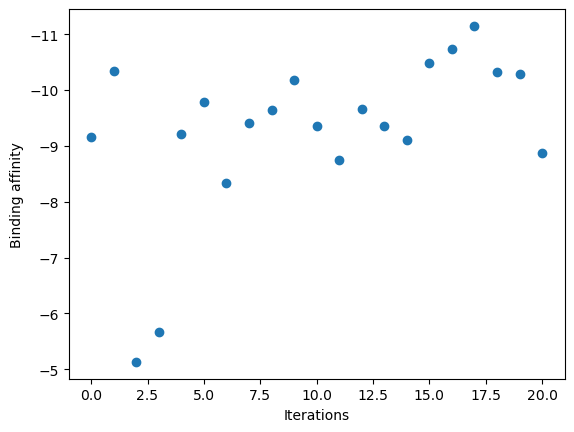

In [23]:
import base64
from google import genai
from google.genai import types
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

from api import get_docking_data

load_dotenv()

protein = "c-met"

system_instructions = "You are an assistant helping a lab generate ligands that can bind to certain proteins with high binding affinity."
client = genai.Client(api_key=os.environ["API_KEY"])
chat = client.chats.create(model="gemini-2.0-flash", config=types.GenerateContentConfig(system_instruction=system_instructions))

init_prompt = f"Generate a ligand that can bind to {protein} with high binding affinity. Provide only your final answer in SMILES encoding format, and make sure that the SMILES string is valid."
response = chat.send_message(init_prompt)
ligand = response.text

data = get_docking_data(ligand, protein)
invalid_ligand = False
if data:
    print(f"Initial generation: Molecule: {ligand} | Binding affinity: {data["binding_affinity"] if not invalid_ligand else 0}")
else:
    print("Initial generation: Invalid ligand")
    invalid_ligand = True

num_iterations = 50
affinities = [data["binding_affinity"]] if not invalid_ligand else []
best_affinity = data["binding_affinity"] if not invalid_ligand else 0
best_molecule = ligand
best_iteration = 0
for i in range(num_iterations):
    iterated_prompt = ""
    if not invalid_ligand:
        # iterated_prompt = [f"""Software shows that the molecule you generated, {ligand}, had a binding affinity of {data["binding_affinity"]} to {protein}.
        #                     Additionally, the torsional energy was {data["torsional_energy"]}, the number of rotatable bonds was {data["number_of_rotatable_bonds"]},
        #                     the number of hydrogen bonds was {data["hydrogen_bonds"]}, the number of pi pi stacking interactions was {data["pi_pi_stacking_interactions"]},
        #                     the number of salt bridges was {data["salt_bridges"]}, and the number of t stacking interactions was {data["t_stacking_interactions"]}. 
        #                     Three pictures of the interaction between the ligand and protein are also included.
        #                     Based on this information, generate a better ligand, following the same answer format""",
        #                     types.Part.from_bytes(data=data["images"]["view0"], mime_type="image/jpeg"), types.Part.from_bytes(data=data["images"]["view1"], mime_type="image/jpeg"), types.Part.from_bytes(data=data["images"]["view2"], mime_type="image/jpeg")]

        # iterated_prompt = [f"""Software shows that the molecule you generated, {ligand}, had a binding affinity of {data["binding_affinity"]} to {protein}.
        #                    3 pictures of the interaction between the ligand and protein are also included.
        #                     Based on this information, generate a better ligand, following the same answer format""",
        #                     types.Part.from_bytes(data=data["images"]["view0"], mime_type="image/jpeg"), types.Part.from_bytes(data=data["images"]["view1"], mime_type="image/jpeg"), types.Part.from_bytes(data=data["images"]["view2"], mime_type="image/jpeg")]
        
        iterated_prompt = f"""Software shows that the molecule you generated, {ligand}, had a binding affinity of {data["binding_affinity"]} to {protein}. 
        Based on this information, generate a better ligand, following the same answer format"""
    else:
        iterated_prompt = f"Software shows that the molecule you generated, {ligand}, had a binding affinity of 0 to {protein}. Generate a new ligand, following the same answer format."
    try:
        response = chat.send_message(iterated_prompt)
        ligand = response.text

        data = get_docking_data(ligand, protein)
        if(data):
            invalid_ligand=False
            affinities.append(data["binding_affinity"])
            if data["binding_affinity"]<best_affinity:
                best_affinity = data["binding_affinity"]
                best_molecule = ligand
                best_iteration = i+1
            print(f"Iteration {i+1}: Molecule: {ligand} | Binding affinity: {data["binding_affinity"]}")
            open('view0.png', 'wb').write(base64.b64decode(data['images']['view0']))
            open('view1.png', 'wb').write(base64.b64decode(data['images']['view1']))
            open('view2.png', 'wb').write(base64.b64decode(data['images']['view2']))
        else:
            invalid_ligand=True
            print(f"Iteration {i+1}: Invalid ligand")
    except:
        break
    
print(f"Best ligand: {best_molecule} with binding affinity {best_affinity} at iteration {best_iteration}")
scatter = plt.scatter(range(len(affinities)), affinities)
plt.xlabel("Iterations")
plt.ylabel("Binding affinity")
ax = scatter.axes
ax.invert_yaxis()
plt.show()



In [24]:
from scipy.stats import pearsonr

print(pearsonr(range(len(affinities)), affinities))

PearsonRResult(statistic=np.float64(-0.49607116195542816), pvalue=np.float64(0.022187011822134232))
